##Install Libraries

In [3]:
!pip install --upgrade scikit-learn lightgbm xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


##Importing Libraries

In [5]:
# Filter warnings
import warnings
warnings.filterwarnings(action="ignore")

# Progress Bar
from tqdm.auto import tqdm
tqdm.pandas()

# Tabulate and random utilities
from tabulate import tabulate
import random
import os

# Data Preprocessing
import numpy as np
import pandas as pd
from itertools import combinations

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Scikit-learn utilities
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Machine Learning Models
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

# ML Explainability
import shap
shap.initjs()

##Setting SEED

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Ensure deterministic hashing

set_seed(2025)

In [ ]:
train_df = pd.read_csv("Data/Train (8).csv") 
test_df = pd.read_csv("Data/test (7).csv")

print(f"Train shape: {train_df.shape}\nTest shape: {test_df.shape}")

Train shape: (7307, 9)
Test shape: (1292, 8)


In [9]:
# Drop Train ID
train_df.drop("ID", axis=1, inplace=True)
# Store Test ID
test_id = pd.DataFrame(test_df.pop("ID"))

In [10]:
for i, j in zip([train_df,test_df], ["Train Info:", "Test info:"]):
    print(j)
    i.info()
    print("\n")

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   7307 non-null   float64
 1   Humidity      7307 non-null   float64
 2   MQ7_analog    7307 non-null   float64
 3   MQ9_analog    7307 non-null   float64
 4   MG811_analog  7307 non-null   float64
 5   MQ135_analog  7307 non-null   float64
 6   device_name   7307 non-null   object 
 7   CO2           7307 non-null   float64
dtypes: float64(7), object(1)
memory usage: 456.8+ KB


Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1292 non-null   float64
 1   Humidity      1292 non-null   float64
 2   MQ7_analog    1292 non-null   float64
 3   MQ9_analog    1292 non-null   float64
 4   MG811_analog  12

In [11]:
total_df = pd.concat([train_df, test_df], axis=0) #Combined train and test dataset

print(f"Total shape: {total_df.shape}")

total_df.head()

Total shape: (8599, 8)


,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50
3,31.580,59.220,2844.0,1597.0,4310.0,2723.0,alpha,642.50
4,31.690,62.030,3159.5,1120.5,5519.5,1219.0,alpha,622.00


In [12]:
enc_total_df = pd.get_dummies(total_df, columns=["device_name"], dtype=np.int64)

enc_total_df.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,device_name_alpha,device_name_beta,device_name_charlie
0,28.975,74.475,2480.0,3476.5,1572.0,1997.0,585.75,1,0,0
1,31.900,66.500,3813.0,2726.0,4145.0,3180.0,613.00,1,0,0
2,31.675,60.015,2811.0,1563.5,4250.0,2708.5,616.50,1,0,0
3,31.580,59.220,2844.0,1597.0,4310.0,2723.0,642.50,1,0,0
4,31.690,62.030,3159.5,1120.5,5519.5,1219.0,622.00,1,0,0


##Plot Features Distribution

In [13]:
def PlotDist(df, col):
    num_plots = len(col)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    plt.figure(figsize=(5 * num_cols, 4 * num_rows))

    for i, j in enumerate(col, start=1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[j], kde=True)
        plt.title(f"Distribution of {j}")

    plt.tight_layout()
    plt.show()

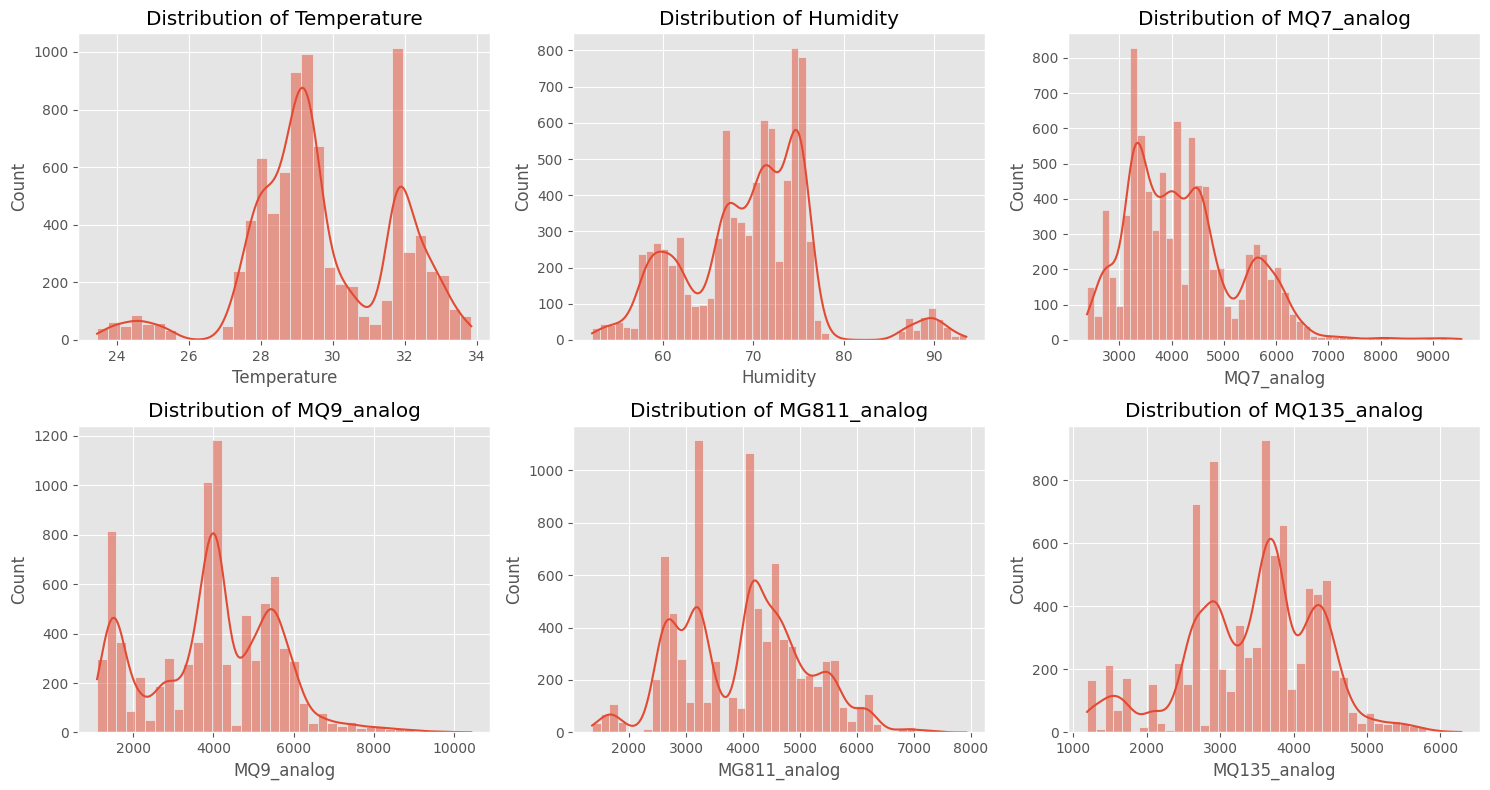

In [14]:
PlotDist(enc_total_df, enc_total_df.columns[:-4])

In [15]:
log_trans_df = enc_total_df.copy()

for i in enc_total_df.columns[:-4]:
    log_trans_df[i] = np.log10(1+ log_trans_df[i]) #Apply log transform for the features

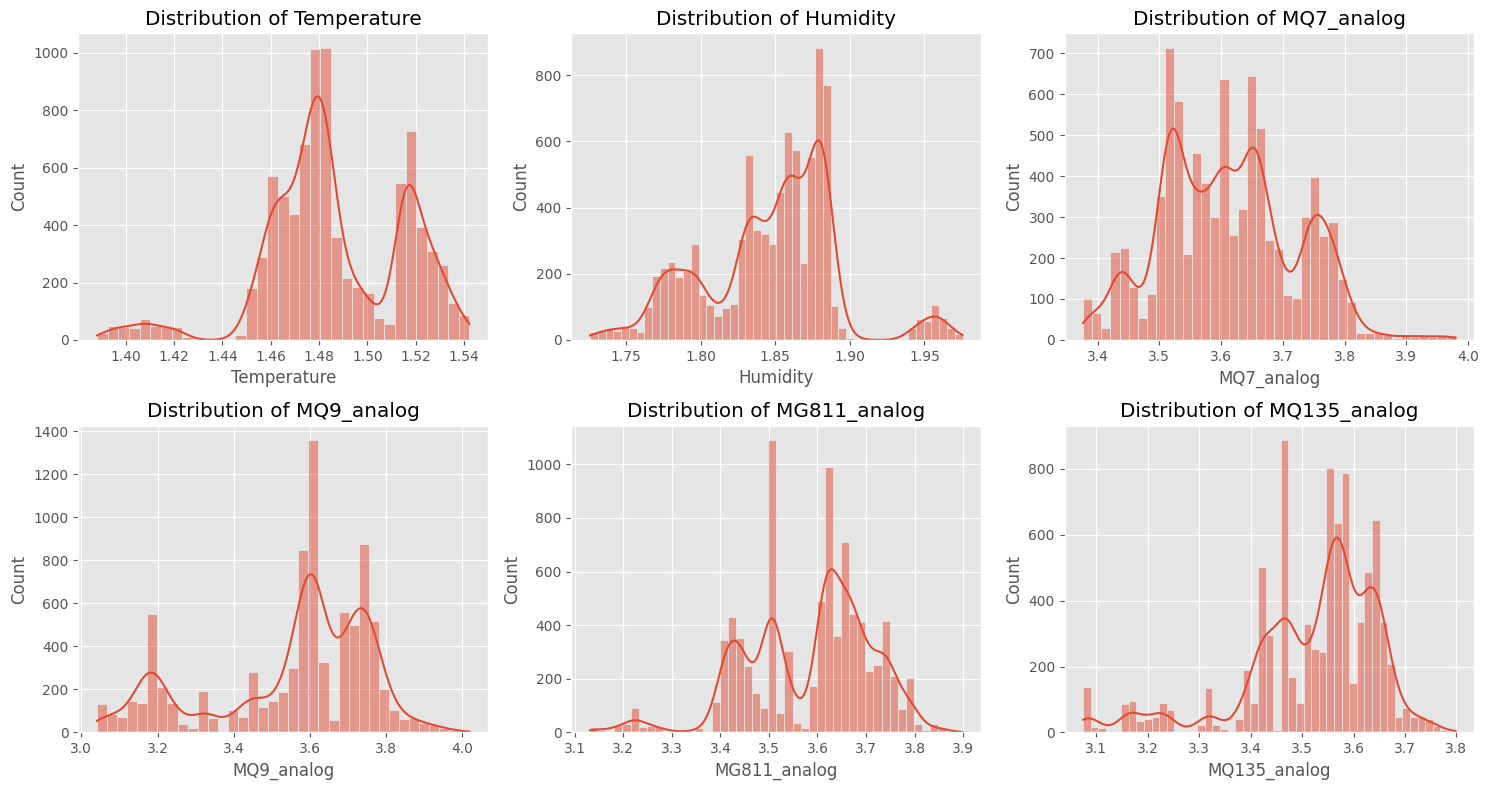

In [16]:
PlotDist(log_trans_df, log_trans_df.columns[:-4])

In [17]:
def TrainFold(X, y, Xtest, algos, cv=10, shuffle=False, random_state=2025):
    kfcv = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state) if shuffle else KFold(n_splits=cv)

    test_pred = {"model_name":[], "pred":[]}
    trained_models = {}

    for algo in algos:
        init_algo = algo(verbosity=0) if (algo.__name__ == "XGBRegressor") else \
                    algo(verbose=0) if (algo.__name__ == "CatBoostRegressor") else \
                    algo(verbose=-1) if (algo.__name__ == "LGBMRegressor") else \
                    algo()

        pred_per_fold = {"train":[], "val":[], "test":[]}
        score_per_fold = {"train":[], "val":[]}
        for fold, (train_idx, val_idx) in tqdm(enumerate(kfcv.split(X, y), start=1), desc=f"Training {algo.__name__}", total=cv):
            xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
            xtest, yval = X.iloc[val_idx], y.iloc[val_idx]

            init_algo.fit(xtrain, ytrain)

            for i, j in zip(["train", "val"], [xtrain, xtest]):
                pred = init_algo.predict(j)
                pred_per_fold[i].append(pred)
                score_per_fold[i].append(np.sqrt(mean_squared_error(ytrain if i=="train" else yval, pred)))

            pred_per_fold["test"].append(init_algo.predict(Xtest))

        # Store trained model
        trained_models[algo.__name__] = init_algo

        # Print RMSE scores using tabulate
        score_table = [[fold+1, train_rmse, val_rmse] for fold, (train_rmse, val_rmse) in enumerate(zip(score_per_fold["train"], score_per_fold["val"]))]
        score_table.append(["Average", np.mean(score_per_fold["train"]), np.mean(score_per_fold["val"])])

        print(f"\nScores for {algo.__name__} (RMSE per fold):\n")
        print(tabulate(score_table, headers=["Fold", "Train RMSE", "Val RMSE"], tablefmt="grid"))

        test_pred["model_name"].extend([algo.__name__]*len(Xtest))
        test_pred["pred"].extend(np.mean(pred_per_fold["test"], axis=0))

    return pd.DataFrame(test_pred), trained_models

def FeatureInteraction(df, col):
    new_features = pd.DataFrame()

    for f1, f2 in combinations(col, 2):
        # Multiply features
        new_features[f'{f1}_x_{f2}'] = df[f1] * df[f2]

        # Divide features (skip division by 0)
        new_features[f'{f1}_div_{f2}'] = np.where(df[f2] != 0, df[f1] / df[f2], np.nan)
        new_features[f'{f2}_div_{f1}'] = np.where(df[f1] != 0, df[f2] / df[f1], np.nan)

        # Add features
        new_features[f'{f1}_plus_{f2}'] = df[f1] + df[f2]

        # Subtract features (both directions)
        new_features[f'{f1}_minus_{f2}'] = df[f1] - df[f2]
        new_features[f'{f2}_minus_{f1}'] = df[f2] - df[f1]

    # Optionally, you can add back the original features to the dataframe
    df_with_new_features = pd.concat([df, new_features], axis=1)

    return df_with_new_features

def SND_Feature(df, col):
    new_df = pd.DataFrame()

    for f1, f2 in combinations(col, 2):
        new_df[f"SND_{f1}_{f2}"] = (df[f1] - df[f2])/df[f1] + df[f2]

    df_with_new_features = pd.concat([df, new_df], axis=1)

    return df_with_new_features

## Feature Interaction

In [18]:
exp_df = FeatureInteraction(log_trans_df, ["MQ7_analog","MQ9_analog","MG811_analog","MQ135_analog"])

exp_df.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,device_name_alpha,device_name_beta,device_name_charlie,...,MQ135_analog_div_MQ9_analog,MQ9_analog_plus_MQ135_analog,MQ9_analog_minus_MQ135_analog,MQ135_analog_minus_MQ9_analog,MG811_analog_x_MQ135_analog,MG811_analog_div_MQ135_analog,MQ135_analog_div_MG811_analog,MG811_analog_plus_MQ135_analog,MG811_analog_minus_MQ135_analog,MQ135_analog_minus_MG811_analog
0,1.476759,1.877803,3.394627,3.541267,3.196729,3.300595,585.75,1,0,0,...,0.932038,6.841863,0.240672,-0.240672,10.551108,0.968531,1.032492,6.497324,-0.103867,0.103867
1,1.517196,1.829304,3.581381,3.435685,3.617629,3.502564,613.00,1,0,0,...,1.019466,6.938249,-0.066879,0.066879,12.670977,1.032852,0.968193,7.120193,0.115066,-0.115066
2,1.514216,1.785437,3.449015,3.194376,3.628491,3.432889,616.50,1,0,0,...,1.074667,6.627265,-0.238514,0.238514,12.456208,1.056979,0.946093,7.061380,0.195602,-0.195602
3,1.512951,1.779741,3.454082,3.203577,3.634578,3.435207,642.50,1,0,0,...,1.072304,6.638784,-0.231630,0.231630,12.485528,1.058038,0.945146,7.069785,0.199371,-0.199371
4,1.514415,1.799547,3.499756,3.049799,3.741978,3.086360,622.00,1,0,0,...,1.011988,6.136159,-0.036561,0.036561,11.549092,1.212425,0.824794,6.828338,0.655619,-0.655619


In [19]:
extra_feature = SND_Feature(exp_df, ["Temperature", "Humidity", "MQ7_analog", "MQ9_analog", "MG811_analog", "MQ135_analog"])

extra_feature.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,device_name_alpha,device_name_beta,device_name_charlie,...,SND_Humidity_MQ7_analog,SND_Humidity_MQ9_analog,SND_Humidity_MG811_analog,SND_Humidity_MQ135_analog,SND_MQ7_analog_MQ9_analog,SND_MQ7_analog_MG811_analog,SND_MQ7_analog_MQ135_analog,SND_MQ9_analog_MG811_analog,SND_MQ9_analog_MQ135_analog,SND_MG811_analog_MQ135_analog
0,1.476759,1.877803,3.394627,3.541267,3.196729,3.300595,585.75,1,0,0,...,2.586862,2.655411,2.494352,2.542906,3.498069,3.255026,3.328296,3.294021,3.368558,3.268104
1,1.517196,1.829304,3.581381,3.435685,3.617629,3.502564,613.00,1,0,0,...,2.623597,2.557547,2.640030,2.587866,3.476367,3.607508,3.524571,3.564672,3.483098,3.534371
2,1.514216,1.785437,3.449015,3.194376,3.628491,3.432889,616.50,1,0,0,...,2.517266,2.405247,2.596220,2.510172,3.268205,3.576454,3.437565,3.492591,3.358222,3.486796
3,1.512951,1.779741,3.454082,3.203577,3.634578,3.435207,642.50,1,0,0,...,2.513304,2.403552,2.592383,2.505034,3.276101,3.582322,3.440672,3.500041,3.362903,3.490061
4,1.514415,1.799547,3.499756,3.049799,3.741978,3.086360,622.00,1,0,0,...,2.554958,2.355040,2.662579,2.371284,3.178367,3.672767,3.204481,3.515019,3.074372,3.261566


## Split data

In [20]:
trainX = extra_feature.iloc[:train_df.shape[0]].drop("CO2", axis=1)
testX = extra_feature.iloc[train_df.shape[0]:].drop("CO2", axis=1)

## Predict data

In [21]:
test_pred, train_model = TrainFold(trainX,
                                   total_df[:train_df.shape[0]]["CO2"],
                                   testX,
                                   [Ridge, Lasso,ExtraTreesRegressor]) #list of models

Training Ridge:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for Ridge (RMSE per fold):

+---------+--------------+------------+
| Fold    |   Train RMSE |   Val RMSE |
+=========+==============+============+
| 1       |      15.6584 |    14.0055 |
+---------+--------------+------------+
| 2       |      15.5874 |    14.6134 |
+---------+--------------+------------+
| 3       |      15.5845 |    14.7769 |
+---------+--------------+------------+
| 4       |      15.5246 |    15.06   |
+---------+--------------+------------+
| 5       |      15.3309 |    16.628  |
+---------+--------------+------------+
| 6       |      15.3838 |    16.2192 |
+---------+--------------+------------+
| 7       |      15.3802 |    16.2416 |
+---------+--------------+------------+
| 8       |      15.4256 |    16.063  |
+---------+--------------+------------+
| 9       |      15.4804 |    15.5089 |
+---------+--------------+------------+
| 10      |      15.3806 |    16.4585 |
+---------+--------------+------------+
| Average |      15.4737 |    15.5575 |
+---

Training Lasso:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for Lasso (RMSE per fold):

+---------+--------------+------------+
| Fold    |   Train RMSE |   Val RMSE |
+=========+==============+============+
| 1       |      16.5289 |    15.7891 |
+---------+--------------+------------+
| 2       |      16.489  |    16.2809 |
+---------+--------------+------------+
| 3       |      16.4415 |    16.6679 |
+---------+--------------+------------+
| 4       |      16.4978 |    15.7273 |
+---------+--------------+------------+
| 5       |      16.3506 |    17.0739 |
+---------+--------------+------------+
| 6       |      16.3898 |    16.4756 |
+---------+--------------+------------+
| 7       |      16.3832 |    16.7859 |
+---------+--------------+------------+
| 8       |      16.411  |    16.6708 |
+---------+--------------+------------+
| 9       |      16.4799 |    16.0964 |
+---------+--------------+------------+
| 10      |      16.3542 |    17.2337 |
+---------+--------------+------------+
| Average |      16.4326 |    16.4802 |
+---

Training ExtraTreesRegressor:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for ExtraTreesRegressor (RMSE per fold):

+---------+--------------+------------+
| Fold    |   Train RMSE |   Val RMSE |
+=========+==============+============+
| 1       |  0.000469573 |    4.52973 |
+---------+--------------+------------+
| 2       |  0.000237914 |    4.6582  |
+---------+--------------+------------+
| 3       |  0.000275743 |    4.4219  |
+---------+--------------+------------+
| 4       |  0.0010504   |    4.81526 |
+---------+--------------+------------+
| 5       |  0.000370233 |    5.51921 |
+---------+--------------+------------+
| 6       |  0.000209092 |    4.70992 |
+---------+--------------+------------+
| 7       |  0.000836369 |    4.91935 |
+---------+--------------+------------+
| 8       |  0.000246613 |    5.45501 |
+---------+--------------+------------+
| 9       |  0.000358836 |    6.06089 |
+---------+--------------+------------+
| 10      |  0.000380056 |    5.42756 |
+---------+--------------+------------+
| Average |  0.000443483 |    

## ML EXLPLAINABILITY

In [22]:
explainer = shap.Explainer(train_model["ExtraTreesRegressor"].predict, trainX[:100])
shap_values = explainer(testX[:100])

PermutationExplainer explainer: 101it [01:12,  1.25it/s]


## Feature Importance

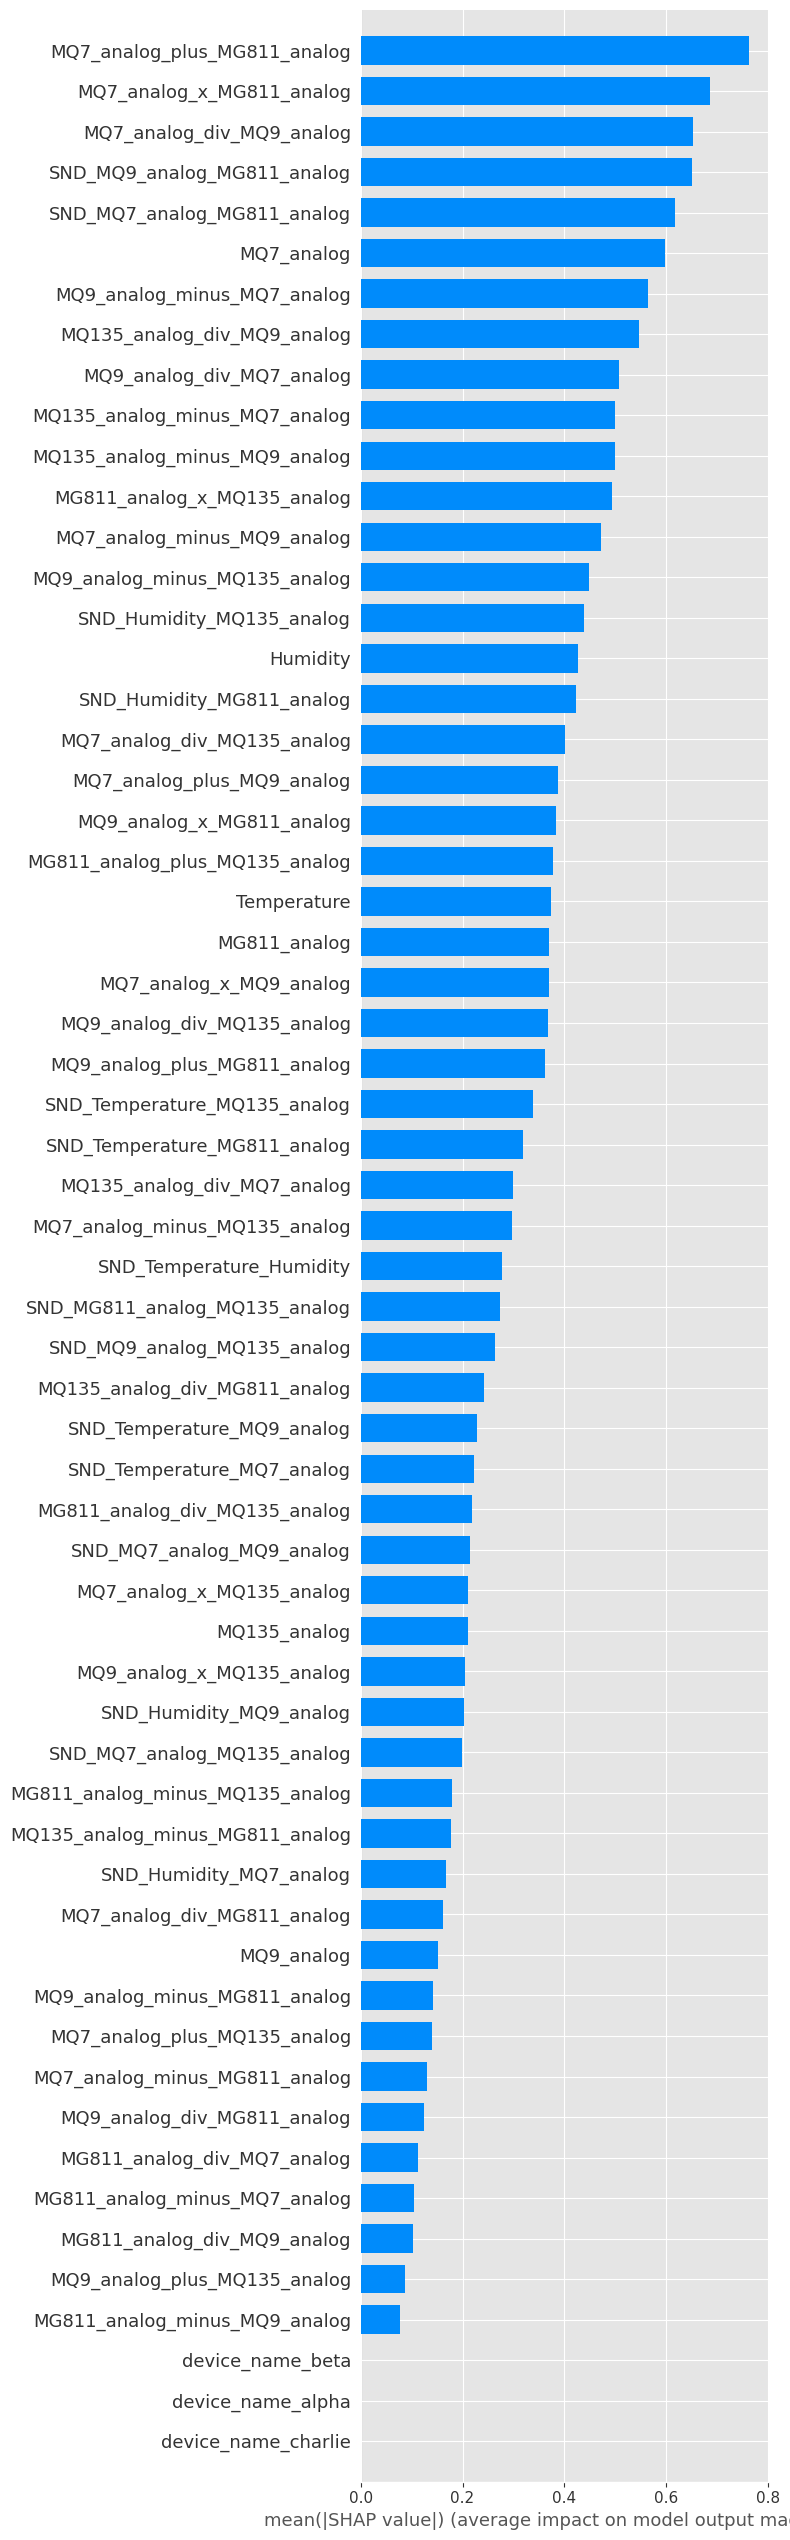

In [25]:
shap.summary_plot(shap_values, max_display=len(trainX.columns), plot_type="bar")

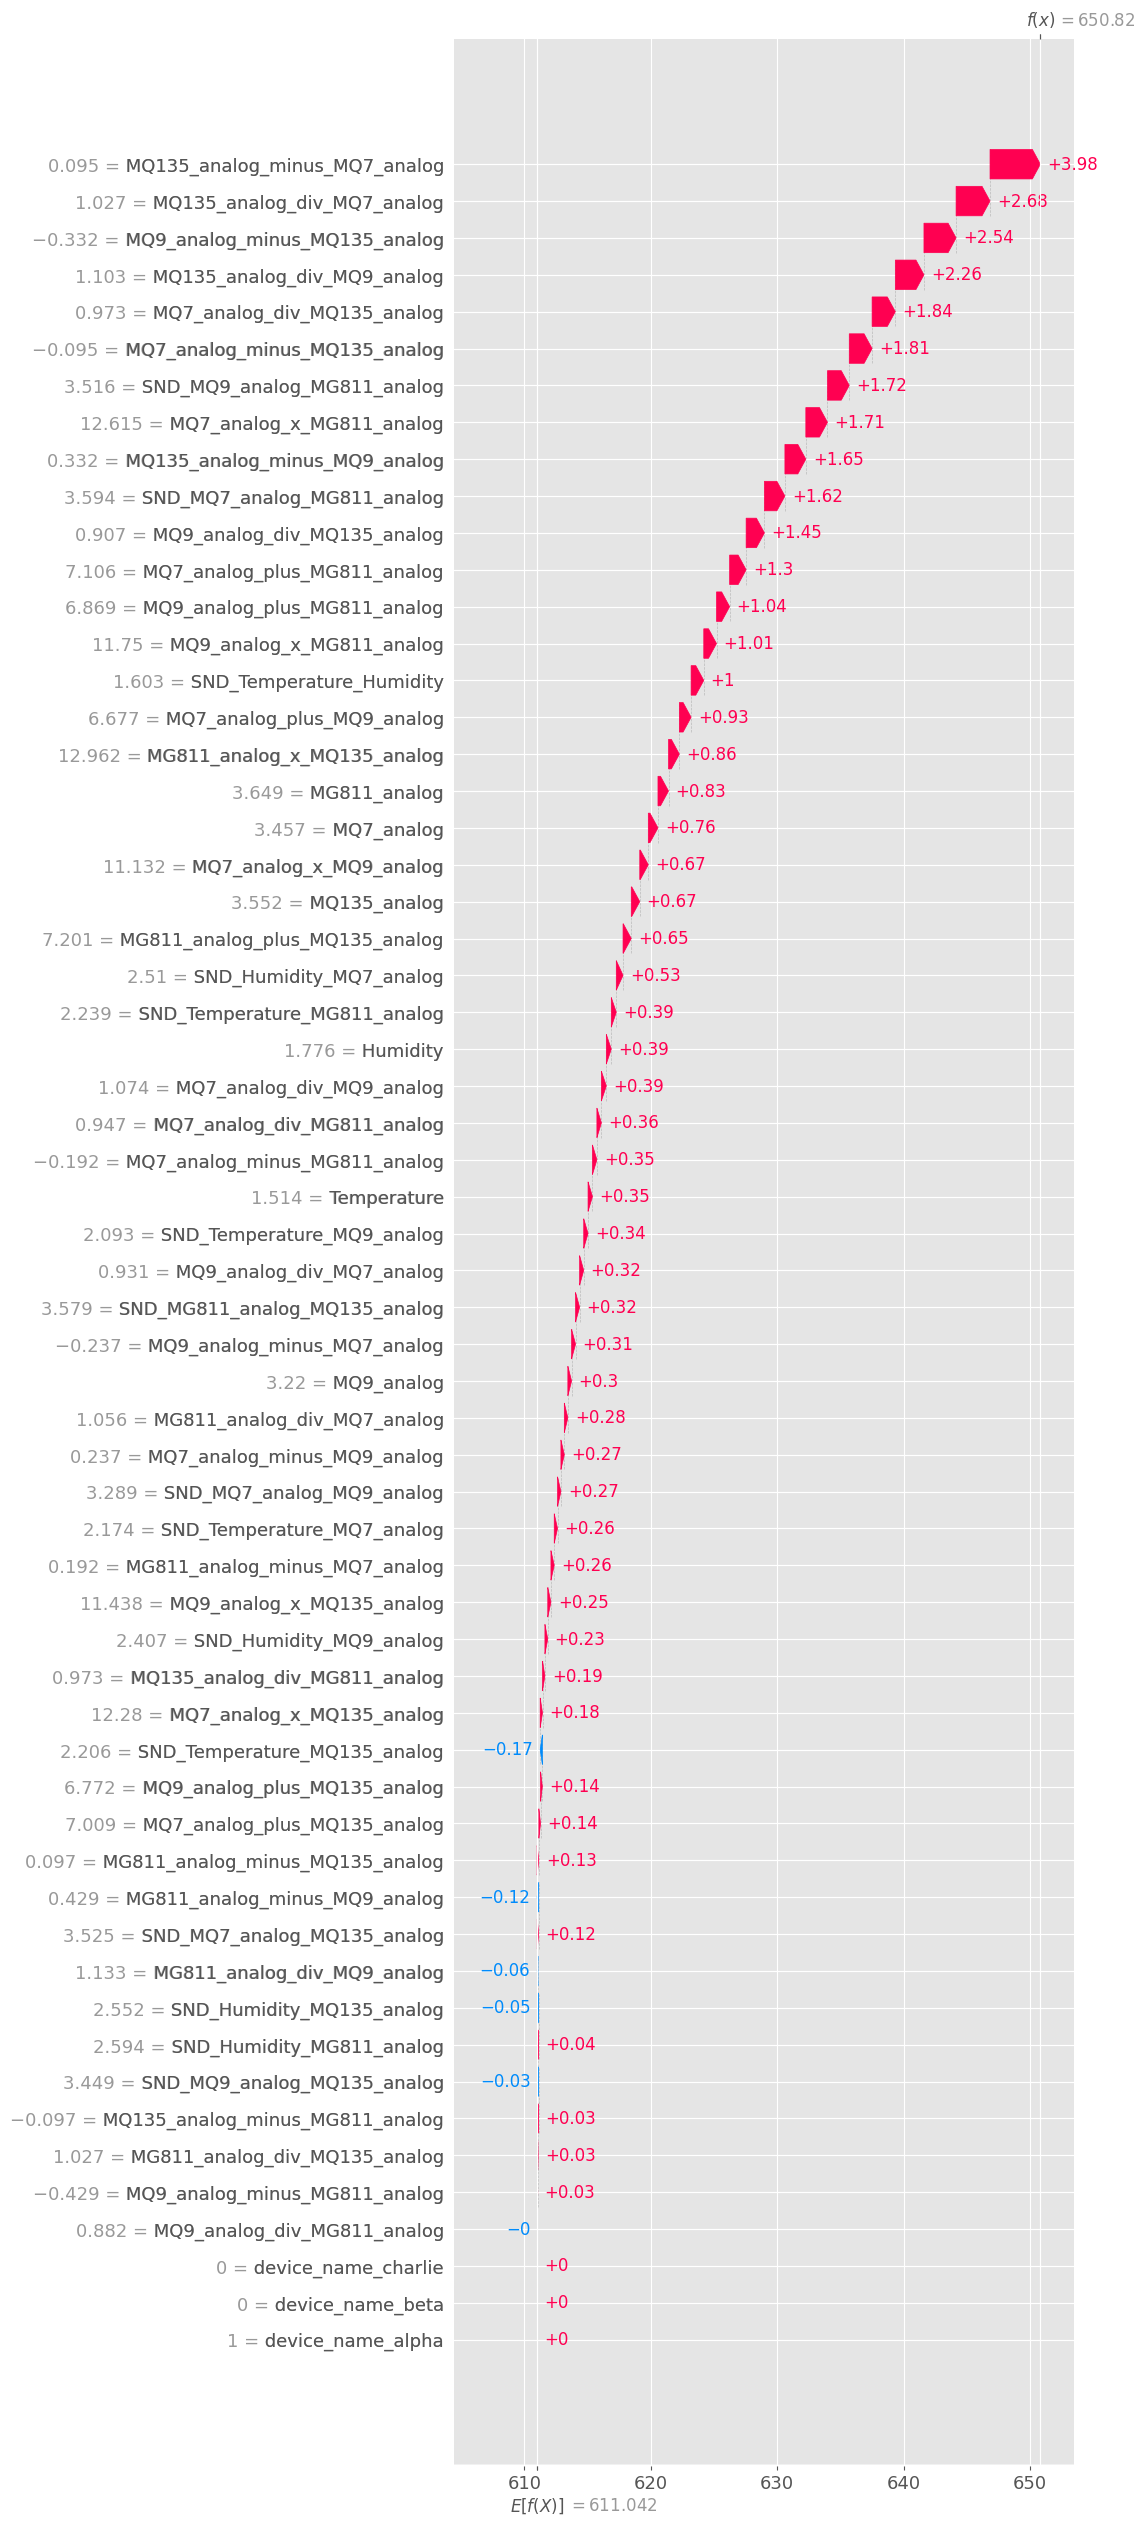

In [26]:
shap.plots.waterfall(shap_values[1], max_display=len(trainX.columns))

##Feature Correlation

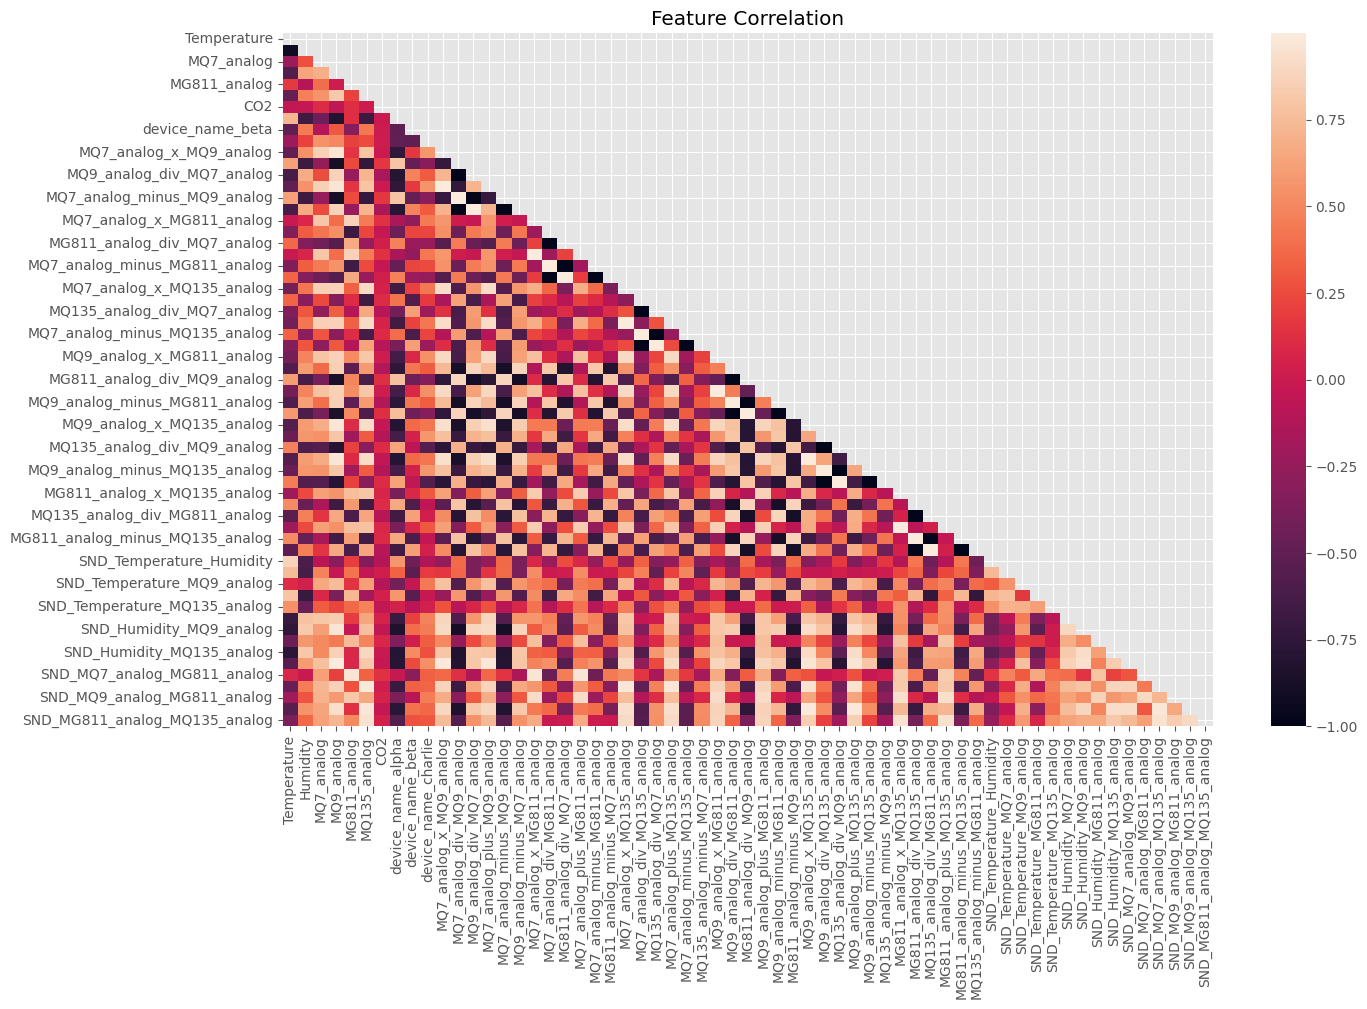

In [28]:
plt.figure(figsize=(15, 9))
sns.heatmap(extra_feature.corr(), mask=np.triu(np.ones_like(extra_feature.corr())))
plt.title("Feature Correlation")
plt.show()

##Creating Submission

In [27]:
for i in ["ExtraTreesRegressor"]:
    test_id["CO2"] = test_pred[test_pred["model_name"] == i].drop("model_name", axis=1).reset_index(drop=True)
    test_id.to_csv(f"result/{i}_10fold.csv", index=False)
    test_id.drop("CO2", axis=1, inplace=True)

##Thank You